# Introduction
La première étape consiste à importer des librairies nécessaires. En particulier, nous allons importer la librairie `ollama`, qui permet d'interagir avec le LLM.

In [1]:
from ollama import Client

#ces autres librairies sont utilisées pour la visualisation et le traitement des données
import pandas as pd
import json
import sklearn
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

### Fil rouge: analyse de publications scientifiques
Afin d'explorer les différentes possibilitées d'interaction avec les LLMs, nous allons prendre un fil rouge: l'analyse de publications scientifiques d'un laboratoire. L'objectif est d'arriver a automatiquement dégager des grands thèmes dans les travaux du laboratoire, par exemple pour redéfinir des équipes ou des poles, ou pour mettre en avant les changements au cours du temps.


Pour ce faire, nous allons utiliser une petite librairie python permettant de récupérer des données depuis la base de données HAL.
Nous téléchargons la bibliothèquee, puis importons les fonctions nécessaires.

In [10]:
#télécharge le code pour interroger HAL
#!wget https://raw.githubusercontent.com/Yquetzal/Teaching_notebooks/main/Networks/HALfunctions.py (ne marche pas sur certaines configurations)
import urllib.request

url  = "https://raw.githubusercontent.com/Yquetzal/Teaching_notebooks/main/Networks/HALfunctions.py"
path = "HALfunctions.py"          # where to save

urllib.request.urlretrieve(url, path)


('HALfunctions.py', <http.client.HTTPMessage at 0x7f9db1cb1e80>)

In [5]:
# Importe une fonction pour interroger HAL, `get_all_elements`
from HALfunctions import get_all_elements

### Requete à l'API HAL
Sans rentrer dans les détails, il est possible d'interroger l'API HAL en renseignant des critères, tels que des mots clefs, des noms d'auteurs, ou des institutions. Ici, a titre d'exemple, on va chercher toutes les publications par les membres du laboratoire LIRIS (`structId_i:2003`) entre 2023 et 2024. On récupère les résultats sous la forme d'un fichier csv, qui contient des colonnes utiles. En particulier, ici nous allons utiliser le titre (`title_s`)  et le résumé (`abstract_s`).

In [5]:
q="structId_i:2003"
domaine=""
dates="[2025 TO 2025]"
colonnes_voulues="title_s,abstract_s,authFullName_s,level1_domain_s,keyword_s,instStructCountry_s"

requete = "http://api.archives-ouvertes.fr/search/"+domaine+"?q="+q+"&fq=publicationDate_s:"+dates+"&fl="+colonnes_voulues
LIRISpublications = get_all_elements(requete)
# Affiche les 10 premières publications
LIRISpublications[:3]

NameError: name 'get_all_elements' is not defined

### Fil rouge: analyse
On observe que les données de HAL sont mal remplies: les mots-clefs, les domaines scientifiques sont souvent manquant. 
Pour arriver a un bon résultat, il est donc nécessaire de traiter directement le texte: titre et/ou résumé. Cependant, se baser uniquement sur les mots communs comme mots-clefs fonctionnerait mal (ex.: `LLM` différent de `ChatGPT`, mais globalement des synonymes )

Nous allons donc chercher à utiliser les LLMs pour identifier des articles dont les contenus seraient similaires, mais qui n'utiliseraient pas les mêmes mots

# LLM: initialisation
Dans cette première partie, nous allons nous connecter à un service de LLM. Pour se connecter, il faut renseigner une URL où se trouve le service (API), et une clef, jouant un rôle similaire à un mot de passe (API KEY). 
On peut noter que l'URL peut être locale à la machine, si le LLM est installé sur la même machine, un serveur privé, par exemple insitutionnel, ou un service payant type OpenAI.

Pour que ce code fonctionne, vous devez renseigner une URL et un API_KEY valides.

In [69]:
# YOUR_API_KEY="..."
# client = Client(
  
#   host='https://ollama-ui.pagoda.liris.cnrs.fr/ollama',
#   headers={'Authorization': f'Bearer {YOUR_API_KEY}'}
# )


In [7]:
client = Client(  
  host='http://localhost:11434',
) 

# Choix du modèle
Pour un même service de LLM, il est souvent possible de choisir parmi plusieurs modèles, plus ou moins puissants.
Si certains modèles sont plus puissants (et donc plus demandeurs en temps de calcul), il existe d'autres spécificités:
* Certains modèles sont *multimodaux*, ce qui veut dire qu'ils comprennent non seulement le texte, mais aussi les images, voires d'autres sources telles que des PDF, des vidéos, des sons...
* Certains modèles sont des modèles *avec raisonnement*. Ils ne répondent pas d'un coup, mais ont un processus d'interrogation et d'évaluation de leurs propres réponses afin de fournir des résultats plus pertinents, mais aussi nettement plus couteux
* Certains modèles spécifiques sont des modèles *d'embedding*, ou de plongement. Ils ne fournissent pas des réponses textuelles, mais sous forme mathématique (des vecteurs, c'est à dire des suites de nombres). Nous verrons leur usage ultérieurement.

Le nom des modèles disponibles, avec quelques informations, est disponible ci-dessous

| NAME                  | SIZE   | Type de modèle   |
|-----------------------|--------|------------------|
| bge-m3:latest         | 1.2 GB | Embedding        |
| llama4:latest         | 67 GB  | LLM (texte)      |
| qwen2:7b              | 4.4 GB | LLM (texte)      |
| mistral-large:latest  | 73 GB  | LLM (texte)      |
| deepseek-r1:latest    | 4.7 GB | LLM (code + texte) |
| llama3.3:latest       | 42 GB  | LLM (texte)      |

# Préparation des données
Afin de manipuler plus facilement les données, nous créons un seul texte pour chaque article en concaténant le titre, le résumé et les mots-clefs, lorsque disponibles.
Nous mettons le résultat dans une liste python

In [72]:
LIRISpublications['keyword_s'] = LIRISpublications['keyword_s'].fillna("")
LIRISpublications['abstract_s'] = LIRISpublications['abstract_s'].fillna("")

all_to_summarize = []
for index, publi in LIRISpublications.iterrows():
    to_summarize = publi['title_s'] + ". " + publi['abstract_s'] + ". " + publi["keyword_s"]
    all_to_summarize.append(to_summarize)
    

In [73]:
#visualisation des 3 premières publications de la liste.
print("Nombre de publications à résumer :", len(all_to_summarize))
all_to_summarize[:3]

Nombre de publications à résumer : 27


['Review of driver behaviour modelling for highway on‐ramp merging. . ',
 "London taxi drivers exploit neighbourhood boundaries for hierarchical route planning. Humans show an impressive ability to plan over complex situations and environments. A classic approach to explaining such planning has been tree-search algorithms which search through alternative state sequences for the most efficient path through states. However\\, this approach fails when the number of states is large due to the time to compute all possible sequences. Hierarchical route planning has been proposed as an alternative\\, offering a computationally efficient mechanism in which the representation of the environment is segregated into clusters. Current evidence for hierarchical planning comes from experimentally created environments which have clearly defined boundaries and far fewer states than the real-world. To test for real-world hierarchical planning we exploited the capacity of London licensed taxi drivers to 

# Usage 1: poser une question
Le premier type d'interrogation que l'on peut faire consiste à tout simplement poser une question en langage naturel, et recevoir une réponse, toujours en langage naturel. Il s'agit d'un usage similaire à celui auquel on a accès sur une interface de type ChatGPT. 
On peut noter qu'il ne s'agit pas d'un échange continu de type "chat". Chaque question posée est indépendante de la précédente. Dans les faits, lors d'un chat, la question i+1 consiste à poser la qestion i+1 concaténée à l'ensemble de l'historique de la dicussion jusqu'à i+1 (question i-1, réponse i-1, question i-2, réponse i-2, etc.). 

Ici, nous allons utiliser cette fonctionnalité pour produire un résumé court. Il s'agit d'une pratique courante dans le domaine, cela permet en quelque sorte de concentrer l'information, de manière à 1)réduire les demandes en temps de calcul, et 2)obtenir des résultats plus précis.

Pour ce faire, nous rédigeons tout simplement un *prompt*, un message décrivant ce que nous souhaitons. Ce prompt doit être aussi précis que possible, tout en restant si possible concis. On spécifie bien au modèle que l'on ne souhaite pas avoir de "décoration" autour de la réponse, des message du type "je vais proposer un résumé de 30 mots...".

En utilisant une boucle `for`, on demande un résumé pour chacun des articles dans notre base.

A note qu'à ce stade, on n'effectue pas de vérification des réponses: il est possible que parfois le LLM fasse des réponse de beaucoup plus de 30 mots, ou que par `hallucination`, il réponde quelque chose du type "je n'ai pas réussi à comprendre ce texte", etc. Il serait possible d'ajouter des vérifications pour pallier ce problème.

La notion de `temperature` est une notion très utile pour les LLMs. Elle permet de contrôler approximativement la *créativité*, *l'imagination*, le *degré de fantaisie* du modèle. Plus la valeur est élevée, plus la créativité est forte. En indiquant une température de zéro, le modèle deviens déterministe: si on repose la même question, on aura la même réponse exactement.

In [74]:
all_summaries = []
for text in tqdm(all_to_summarize, desc="Summarizing"):
    response = client.chat(
        model=model,
        options={'temperature': 0},
        messages=[
            {
                'role': 'user',
                'content': (
                    "summarize the following text in about 30 words. "
                    "Focus on the general theme, general picture, not the details. "
                    "The objective later will be to classify those texts in large scientific topics. "
                    "Answer with only the summary of 30 words, nothing else. ONLY 30 words maximum, no explanation: " + text
                ),
            },
        ],
    )
    all_summaries.append(response["message"]['content'])

Summarizing:   0%|          | 0/27 [00:00<?, ?it/s]

Summarizing: 100%|██████████| 27/27 [02:09<00:00,  4.80s/it]


In [75]:
all_summaries[:3]

['This study examines how drivers merge onto highways, focusing on modeling their actions to improve understanding and potentially enhance traffic flow and safety.\n\n\n\n',
 'Humans expertly plan routes in complex environments, like London, by structuring space hierarchically, not simply calculating distances—demonstrating real-world cognitive mapping skills.\n\n\n\n',
 'This research presents a new algorithm for efficiently organizing groups (coalitions) of agents to navigate and solve complex, large-scale problems collaboratively.\n\n\n\n']

In [76]:
#add the summaries to the dataframe
LIRISpublications['summary'] = all_summaries

# Utiliser un modèle d'embedding/plongement
Une utilisation puissante des LLMs consiste à transformer le texte en un vecteur qui résume ce texte. En effet, un LLM est un algorithme qui manipule des représentations numériques du texte, et manipuler les embeddings consiste intuitivement a manipuler directement les valeurs sous-jacentes, plutôt que de les re-transformer en texte. Le principal usage des embeddings consiste à calculer des distances entre eux. 

Prenons un exemple concret, composé de 4 phrases, certaines ayant des mots similaires, mais des significations différentes, tandis que d'autres n'utilisent pas les mêmes mots, mais ont un sens proche. On vérifie que, lorsque l'on calcule la distance entre les vecteurs embedding de ces phrases, la distance correspond plutôt a une distance sémantique.


In [77]:
#Choix du modèle d'embeddings
model="bge-m3:latest"

sentences = [
    "The bank was flooded with water.", # la rive a été inondée d'eau.",
    "The bank on mainstreet is closed on sundays.", # la banque est fermée le dimanche.",
    "The bank on mainstreet is open on sundays.", # la banque est ouverte le dimanche.",
    "He passed away last night.", # il est décédé la nuit dernière.",
    "He died yesterday.", # il est mort hier."
    "Il est mort hier." # phrase en français
]
# Compute embeddings using the Ollama client
embeddings = client.embed(model=model,input=sentences)
embeddings =embeddings["embeddings"]


Text(0.5, 1.0, 'Cosine Similarity Heatmap')

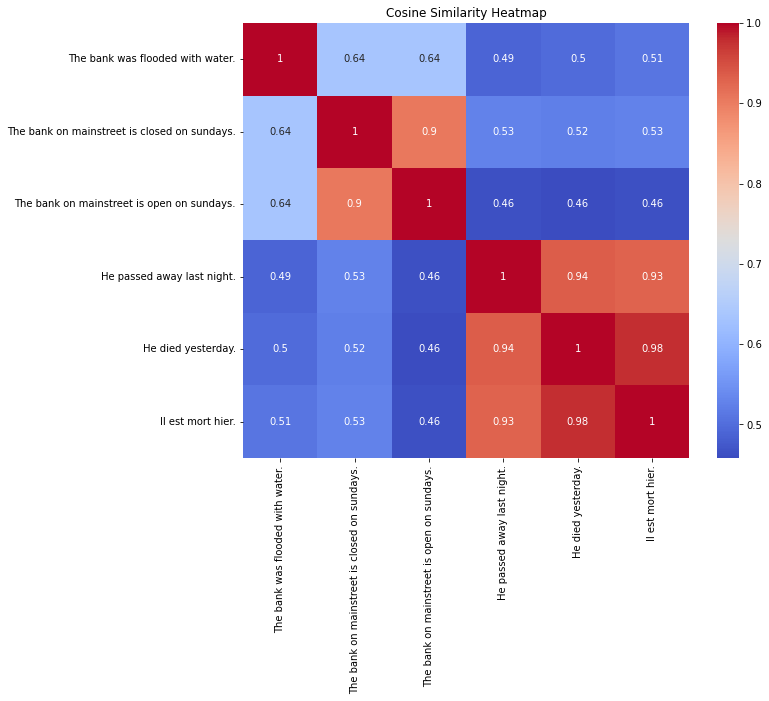

In [78]:
# Compute cosine similarities using sklearn
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(embeddings)

#plot the similarities

plt.figure(figsize=(10, 8))
sns.heatmap(similarities, annot=True, cmap='coolwarm', xticklabels=sentences, yticklabels=sentences)
plt.title("Cosine Similarity Heatmap")

# Fil rouge: Embeddings pour visualisation et obtention de clusters
L'avantage de transformer des phrases en vecteurs est que l'on peut ensuite appliquer des processus classiques d'analyse de données dessus.

Ici, un premier usage est d'obtenir une visualisation des données : en utilisant des méthodes classiques de *réduction de dimension*, on encode chaque élément (article scientifique ici) par un vecteur a 2 dimensions (x,y) de manière à pouvoir les visualiser. Pour ce faire, on utilise UMAP (on pourrait utiliser une ACP, mais UMAP est considéré plus adapté, sans rentrer dans les détails)

### Définition de fonctions utiles
On décompose le code: on commence par écrire 2 fonctions, l'une pour obtenir l'embedding a partir du texte, l'autre pour appliquer une réduction de dimension a ces embeddings

In [79]:
# On définit une fonction pour faire des embeddings de listes de textes
def embed_list(text_list,model_embedding="bge-m3:latest"):
    """
    Function to compute embeddings for a list of texts using the Ollama client.
    Args:
        text_list (list): List of texts to embed.
        model_embedding (str): Model to use for embeddings, default is "bge-m3:latest".
    Returns:
        list: List of embeddings for the input texts.
    """

    all_embeddings = []
    for item in text_list:
        embedding = client.embed(model=model_embedding, input=item)
        all_embeddings.append(embedding["embeddings"][0])
    return all_embeddings

In [80]:
#importation des méthodes de réduction de dimensionnalité
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
#%pip install umap-learn
#import umap.umap_ as umap

In [81]:
def dimension_reduction(embeddings, n_components=2, method='PCA',perplexity=10):
    """
    Function to perform dimensionality reduction on a list of embeddings.
    Args:
        embeddings (list): List of embeddings to reduce.
        n_components (int): Number of components for the reduction, default is 5.
        method (str): Method to use for reduction, can be 'PCA', 'TSNE', or 'UMAP'.
        perplexity (int): Perplexity parameter for t-SNE, default is 30.
    Returns:
        np.ndarray: Reduced embeddings.
    """
    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(embeddings)
    
    if method == 'PCA':
        # Perform PCA
        pca = PCA(n_components=n_components)
        rd_result = pca.fit_transform(embeddings_array)
    elif method == 'TSNE':
        # Perform t-SNE
        tsne = TSNE(n_components=n_components, perplexity=perplexity)
        rd_result = tsne.fit_transform(embeddings_array)
    elif method == 'UMAP':
        # Perform UMAP
        reducer = umap.UMAP(n_components=n_components)
        rd_result = reducer.fit_transform(embeddings_array)

    
    return rd_result


### Execution du processus
On appelle maintenant les fonctions pour effectuer le processus

In [82]:
embeddings = embed_list(all_summaries)
dimension_reduction_result = dimension_reduction(embeddings, n_components=2, method='TSNE', perplexity=10)

In [83]:
# on ajoute les résultats de la réduction de dimensionnalité au dataframe
LIRISpublications['x'] = dimension_reduction_result[:, 0]
LIRISpublications['y'] = dimension_reduction_result[:, 1]

### Visualisation
Finalement, nous visualisation le résultat. Chaque point est un article. La position qu'il occupe dans l'espace doit refléter la distance aux autres articles.

In [84]:
#interactive plot of embeddings after TSNE
import plotly.express as px
fig = px.scatter(LIRISpublications, x='x', y='y',  hover_data=['title_s'])
fig.show()

### Clustering
Une outil classique d'analyse de données est le **clustering** de données : l'objectif est simplement de trouver un nombre déterminé de groupes, tels que les éléments d'un groupe soient aussi similaire entre eux que possible, tandis que des éléments appartenant à des groupes différent sont aussi dissimilaires que possible. L'algorithme classique pour effectuer un tel clustering est *k-means*. Ici, on l'applique et on visualise les résultats. 

In [85]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

def k_means_embeddings(embeddings, n_clusters=5):

    # Normalize the embeddings to unit length
    normalized_embeddings = normalize(embeddings)
    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(normalized_embeddings)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters)

    return kmeans.fit_predict(embeddings_array)

In [86]:
PCA_reduced_embeddings = dimension_reduction(embeddings, n_components=10, method='PCA')
kmeans_labels = k_means_embeddings(PCA_reduced_embeddings, n_clusters=5)
# Add the KMeans labels to the DataFrame
LIRISpublications['kmeans_label'] = kmeans_labels

/Users/remycazabet/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [87]:
#visualisation des clusters avec de larges points et plotly, avec legende categorielle
import plotly.express as px
fig = px.scatter(LIRISpublications, x='x', y='y', color='kmeans_label',
                 hover_data=['title_s'], 
                 title='KMeans Clustering of Summaries',
                 labels={'kmeans_label': 'Cluster'},
                 color_continuous_scale=px.colors.sequential.Viridis)
fig.update_traces(marker=dict(size=10))  # Adjust marker size
fig.show()

# Sorties structurées (Structured outputs)
Lorsque l'on interroge le LLM en mode texte, il est possible de renvoyer son résultat dans un format structuré, le format JSON. Concrètement, certains modèles sont spécifiquement entrainé a renvoyer des réponses dans ce format. Cela est pratique lorsque l'on demande d'extraire des propriétés précises. 

### Fil rouge
Ici, nous allons utiliser les structured outputs pour générer des résumés de chaque cluster d'article obtenu a l'étape précédente. Nous demandons au LLM de renvoyer pour chaque cluster (composé de plusieurs articles) un titre, et une description en 5 mot-clefs. Si l'on ne demandait pas un retour structuré, il serait difficile de récupérer informatiquement ce résultat, qui pourrait être présenté de différentes manières

In [ ]:
import json
from pydantic import BaseModel, Field, ValidationError
from typing import List, Dict, Union

#Nous définissons la forme de la réponse attendue
class ClusterSummary(BaseModel):
    title: str = Field(..., max_length=80)
    keywords: List[str] = Field(..., min_items=3, max_items=3)

def summarize_clusters(
    df: pd.DataFrame,
    cluster_col: str = "cluster",
    col: str = "summary",
    model: str = "gemma3:27b"
) -> Dict[int, Union[ClusterSummary, dict]]:
    result = {}

    for cluster_id, cluster_df in df.groupby(cluster_col):
        texts = " ".join(cluster_df[col].tolist())[:8_000]  # hard-cap 8k chars

        prompt = (
            "You are given a collection of short texts. "
            "Summarize them by generating a concise title (≤ 20 words) and "
            "exactly three single-word keywords.\n\n"
            f"Text collection:\n{texts}"
        )

        try:
            response = client.chat(
                model=model,
                options={'temperature': 0},
                format=ClusterSummary.model_json_schema(),  # <- le schema !
                messages=[{"role": "user", "content": prompt}],
            )
            result[cluster_id] = ClusterSummary.model_validate_json(
                response["message"].content
            )
        except (ValidationError, KeyError) as e:
            result[cluster_id] = {
                "error": str(e),
                "raw_response": getattr(response.choices[0].message, "content", ""),
            }

    return result

In [109]:
summarize_clusters(LIRISpublications, cluster_col='kmeans_label', col='summary')

{0: ClusterSummary(title='Personalized Breathing Model for Improved Lung Cancer Radiation Therapy', keywords=['biomechanics', 'radiation', 'modeling']),
 1: ClusterSummary(title='AI & Human Spatial/Behavioral Understanding: Cognitive Mapping, Prediction & ML', keywords=['cognition', 'analysis', 'prediction']),
 2: ClusterSummary(title='Network Analysis, AI Ethics, and Robust System Design', keywords=['Networks', 'AI', 'Resilience']),
 3: ClusterSummary(title='Advances in Algorithms & Machine Learning for Complex Data & Simulations', keywords=['algorithms', 'machinelearning', 'optimization']),
 4: ClusterSummary(title='Research Highlights: Traffic, Data Security, and Enhanced Learning', keywords=['Research', 'Innovation', 'Technology'])}

# Autres fonctionnalités
## Description d'images
Si l'on utilise un modèle *multimodal*, il est possible de travailler avec des images. Dans ce contexte, on ne s'intéressera pas à la génération d'image, mais seulement a leur analyse. Il est possible de passer une image au modèle, en lui associant un texte, et de recevoir une réponse textuelle en retour. 

In [9]:

reply = client.chat(
    model="gemma3:27b",
    messages=[{
        "role": "user",
        "content": "What is in this image?",
        "images": ["./cat.jpg"]
    }]
)
print(reply["message"]["content"])

Here's what I see in the image:

*   **A cat:** The main subject of the image is a beautiful cat with striking blue eyes. It has a mix of colors - dark patches on its head and lighter, cream-colored fur on its body.
*   **Hexagonal/Octagonal Bed:** The cat is inside a unique-shaped bed. It appears to be made of plastic or a similar material and has a hexagonal or octagonal shape.
*   **Pillow:** The cat is lying on a soft pillow inside the bed. The pillow has a teal/green patterned fabric.
*   **Outdoor setting:** The background suggests that the bed is placed outdoors. There's a concrete wall or structure visible, as well as some grass and gravel.

Overall, the image shows a cat comfortably resting inside a hexagonal/octagonal outdoor bed.
